# P01: Protección ocular frente a radiación láser

Notebook interactivo con: cálculos de H0 y OD requerida, evaluación automática contra un catálogo de gafas (CSV), gráficos comparativos y widgets para escenarios personalizados.

Fuentes base (según práctica):
- Láser 1 (PIV): 532 nm, E = 0.2 J, τ = 8 ns, f = 15 Hz, a = 5 mm, HMPE = 5.0e-7 J/cm².
- Láser 2 (LDA, CW): 514.5 nm, P = 1.5 W, a = 1.2 mm, HMPE = 2.5e-3 W/cm² (0.25 s); para 10 s usar 1.0e-3 W/cm².
- Láser 3 (Alineación, CW): 635 nm, P = 4.5 mW, a = 3 mm, HMPE = 2.5e-3 W/cm² (0.25 s).

Catálogo de gafas (entrada): `../data/epo_lenses.csv` con ≥10 lentes y bandas OD.

In [1]:
# Importaciones con degradación elegante si faltan paquetes
import math, csv, sys, json

try:
    import pandas as pd
    HAS_PANDAS = True
except Exception as e:
    HAS_PANDAS = False

try:
    import matplotlib.pyplot as plt
    import numpy as np
    HAS_MPL = True
except Exception as e:
    HAS_MPL = False

try:
    import ipywidgets as widgets
    from ipywidgets import interact, fixed
    HAS_WIDGETS = True
except Exception as e:
    HAS_WIDGETS = False

DATA_PATH = '../data/epo_lenses.csv'
print(f'Pandas: {HAS_PANDAS}, Matplotlib: {HAS_MPL}, Widgets: {HAS_WIDGETS}')
print('CSV esperado:', DATA_PATH)

Pandas: True, Matplotlib: True, Widgets: True
CSV esperado: ../data/epo_lenses.csv


In [2]:
# Carga de lentes desde CSV (soporta pandas o csv estándar)
def load_lenses(path):
    if HAS_PANDAS:
        df = pd.read_csv(path)
        # normaliza nombres de columnas
        cols = {c: c.strip().lower() for c in df.columns}
        df = df.rename(columns=cols)
        return df
    # Fallback sin pandas: lista de dicts
    rows = []
    with open(path, newline='', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for r in reader:
            rows.append({k.strip().lower(): v for k, v in r.items()})
    return rows

lenses = load_lenses(DATA_PATH)
# Mostrar vista previa
if HAS_PANDAS:
    display(lenses.head(8))
else:
    print('Primeras filas (sin pandas):')
    for r in lenses[:5]:
        print(r)

,lens_id,brand,model,color,vlt_pct,band_lo_nm,band_hi_nm,od_value,notes
0,LENS-001,OptiSafe,MultiShield-7,Amber,30,190.0,534.0,7.0,Alta protección UV-verde
1,LENS-001,OptiSafe,MultiShield-7,Amber,30,900.0,1070.0,6.0,Cubre IR cercano
2,LENS-002,LaserShield,Orange-540,Orange,40,190.0,540.0,5.0,Banda amplia hasta 540 nm
3,LENS-003,SafetyVis,RedIR-Plus,Green,55,630.0,670.0,2.0,Cubre rojos
4,LENS-003,SafetyVis,RedIR-Plus,Green,55,800.0,1100.0,4.0,Cubre IR cercano
5,LENS-004,CobaltTech,Cobalt-Pro,Blue,15,190.0,400.0,7.0,Alta protección UV
6,LENS-004,CobaltTech,Cobalt-Pro,Blue,15,531.9,532.1,6.0,Línea 532 nm
7,LENS-004,CobaltTech,Cobalt-Pro,Blue,15,1063.9,1064.1,5.0,Línea 1064 nm


In [3]:
# Funciones de cálculo (H0, OD requerida) y utilidades de evaluación
def area_cm2_from_diameter_mm(a_mm: float) -> float:
    d_cm = float(a_mm) / 10.0
    return math.pi * (d_cm / 2.0) ** 2

def h0_exposure(laser: dict):
    A = area_cm2_from_diameter_mm(laser['a_mm'])
    if laser['mode'].lower() == 'cw':
        H0 = laser['P_W'] / A
        return H0, 'W/cm^2', A
    else:
        H0 = laser['E_J'] / A
        return H0, 'J/cm^2', A

def od_required(H0: float, HMPE: float) -> float:
    if HMPE <= 0:
        raise ValueError('HMPE debe ser positiva')
    if H0 <= HMPE:
        return 0.0
    return math.log10(H0 / HMPE)

def df_to_rows(df):
    if HAS_PANDAS:
        return df.to_dict(orient='records')
    return df

def available_od_for_lambda(lens_rows, lam_nm: float):
    ods = []
    for r in lens_rows:
        try:
            lo = float(r['band_lo_nm']); hi = float(r['band_hi_nm']); od = float(r['od_value'])
        except Exception:
            continue
        if lo <= lam_nm <= hi:
            ods.append(od)
    return max(ods) if ods else None

def evaluate_against_lenses(laser: dict, lenses_data):
    H0, units, A = h0_exposure(laser)
    od_req = od_required(H0, laser['HMPE'])
    rows = df_to_rows(lenses_data)
    # Agrupar filas por lens_id
    groups = {}
    for r in rows:
        lid = r['lens_id']
        groups.setdefault(lid, []).append(r)
    out = []
    for lid, rs in groups.items():
        od_av = available_od_for_lambda(rs, laser['lambda_nm'])
        brand = rs[0].get('brand',''); model = rs[0].get('model','');
        vlt = float(rs[0].get('vlt_pct', '0') or 0)
        safe = (od_av is not None) and (od_av >= od_req)
        margin = (od_av - od_req) if od_av is not None else None
        out.append({
            'lens_id': lid, 'brand': brand, 'model': model, 'vlt_pct': vlt,
            'lambda_nm': laser['lambda_nm'], 'mode': laser['mode'], 'a_mm': laser['a_mm'],
            'H0': H0, 'H0_units': units, 'HMPE': laser['HMPE'], 'OD_req': od_req,
            'OD_avail': od_av, 'safe': safe, 'margin': margin
        })
    if HAS_PANDAS:
        return pd.DataFrame(out).sort_values(['safe','margin','vlt_pct'], ascending=[False, False, False])
    return out


=== Láser 1 – PIV ===


,lens_id,brand,model,vlt_pct,lambda_nm,mode,a_mm,H0,H0_units,HMPE,OD_req,OD_avail,safe,margin
0,LENS-001,OptiSafe,MultiShield-7,30.0,532.0,pulsed,5.0,1.018592,J/cm^2,5.000000e-07,6.30903,7.0,True,0.69097
10,LENS-011,MultiOptic,TriBand-6,32.0,532.0,pulsed,5.0,1.018592,J/cm^2,5.000000e-07,6.30903,6.0,False,-0.30903
12,LENS-013,ProLaser,BlueCut-6,28.0,532.0,pulsed,5.0,1.018592,J/cm^2,5.000000e-07,6.30903,6.0,False,-0.30903
8,LENS-009,GreenShield,UVG-8,20.0,532.0,pulsed,5.0,1.018592,J/cm^2,5.000000e-07,6.30903,6.0,False,-0.30903
3,LENS-004,CobaltTech,Cobalt-Pro,15.0,532.0,pulsed,5.0,1.018592,J/cm^2,5.000000e-07,6.30903,6.0,False,-0.30903
1,LENS-002,LaserShield,Orange-540,40.0,532.0,pulsed,5.0,1.018592,J/cm^2,5.000000e-07,6.30903,5.0,False,-1.30903
13,LENS-014,SureSafe,UV-VisMix,38.0,532.0,pulsed,5.0,1.018592,J/cm^2,5.000000e-07,6.30903,5.0,False,-1.30903
4,LENS-005,VistaClear,WideVis-3,60.0,532.0,pulsed,5.0,1.018592,J/cm^2,5.000000e-07,6.30903,3.0,False,-3.30903
9,LENS-010,CO2Safe,CO2-Only,90.0,532.0,pulsed,5.0,1.018592,J/cm^2,5.000000e-07,6.30903,NaN,False,NaN
7,LENS-008,RedSafe,Diode-Red3,70.0,532.0,pulsed,5.0,1.018592,J/cm^2,5.000000e-07,6.30903,NaN,False,NaN


Gráfica guardada en: ../data/images/Laser_1___PIV.png


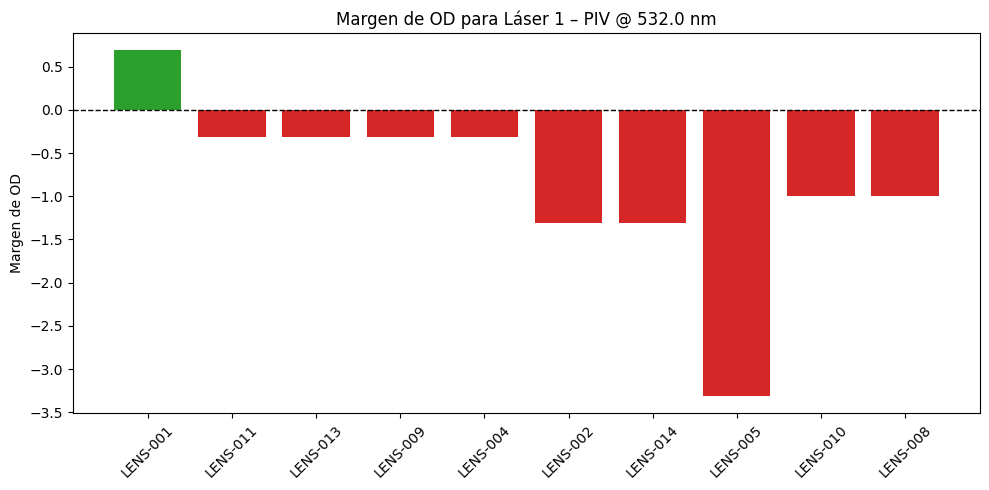


=== Láser 2 – LDA 514.5 ===


,lens_id,brand,model,vlt_pct,lambda_nm,mode,a_mm,H0,H0_units,HMPE,OD_req,OD_avail,safe,margin
0,LENS-001,OptiSafe,MultiShield-7,30.0,514.5,CW,1.2,132.629119,W/cm^2,0.0025,4.724699,7.0,True,2.275301
10,LENS-011,MultiOptic,TriBand-6,32.0,514.5,CW,1.2,132.629119,W/cm^2,0.0025,4.724699,6.0,True,1.275301
5,LENS-006,ArgonGuard,Argon-Line,25.0,514.5,CW,1.2,132.629119,W/cm^2,0.0025,4.724699,6.0,True,1.275301
11,LENS-012,VisiGuard,GreenLine-5,45.0,514.5,CW,1.2,132.629119,W/cm^2,0.0025,4.724699,5.0,True,0.275301
1,LENS-002,LaserShield,Orange-540,40.0,514.5,CW,1.2,132.629119,W/cm^2,0.0025,4.724699,5.0,True,0.275301
13,LENS-014,SureSafe,UV-VisMix,38.0,514.5,CW,1.2,132.629119,W/cm^2,0.0025,4.724699,5.0,True,0.275301
4,LENS-005,VistaClear,WideVis-3,60.0,514.5,CW,1.2,132.629119,W/cm^2,0.0025,4.724699,3.0,False,-1.724699
9,LENS-010,CO2Safe,CO2-Only,90.0,514.5,CW,1.2,132.629119,W/cm^2,0.0025,4.724699,NaN,False,NaN
7,LENS-008,RedSafe,Diode-Red3,70.0,514.5,CW,1.2,132.629119,W/cm^2,0.0025,4.724699,NaN,False,NaN
2,LENS-003,SafetyVis,RedIR-Plus,55.0,514.5,CW,1.2,132.629119,W/cm^2,0.0025,4.724699,NaN,False,NaN


Gráfica guardada en: ../data/images/Laser_2___LDA_514_5.png


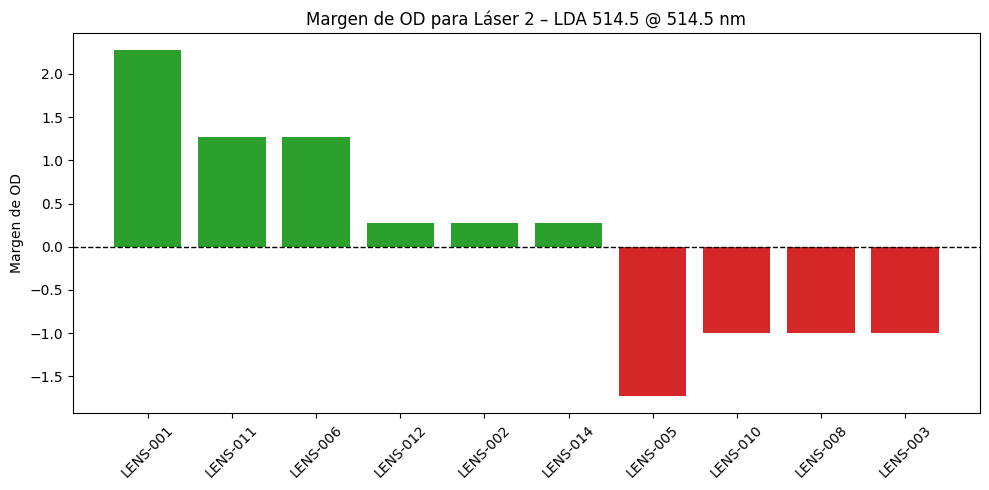

OD_req (exposición larga) @10 s: 5.12

=== Láser 3 – Alineación ===


,lens_id,brand,model,vlt_pct,lambda_nm,mode,a_mm,H0,H0_units,HMPE,OD_req,OD_avail,safe,margin
7,LENS-008,RedSafe,Diode-Red3,70.0,635.0,CW,3.0,0.063662,W/cm^2,0.0025,1.40594,3.5,True,2.09406
4,LENS-005,VistaClear,WideVis-3,60.0,635.0,CW,3.0,0.063662,W/cm^2,0.0025,1.40594,3.0,True,1.59406
2,LENS-003,SafetyVis,RedIR-Plus,55.0,635.0,CW,3.0,0.063662,W/cm^2,0.0025,1.40594,2.0,True,0.59406
11,LENS-012,VisiGuard,GreenLine-5,45.0,635.0,CW,3.0,0.063662,W/cm^2,0.0025,1.40594,2.0,True,0.59406
12,LENS-013,ProLaser,BlueCut-6,28.0,635.0,CW,3.0,0.063662,W/cm^2,0.0025,1.40594,2.0,True,0.59406
9,LENS-010,CO2Safe,CO2-Only,90.0,635.0,CW,3.0,0.063662,W/cm^2,0.0025,1.40594,NaN,False,NaN
1,LENS-002,LaserShield,Orange-540,40.0,635.0,CW,3.0,0.063662,W/cm^2,0.0025,1.40594,NaN,False,NaN
13,LENS-014,SureSafe,UV-VisMix,38.0,635.0,CW,3.0,0.063662,W/cm^2,0.0025,1.40594,NaN,False,NaN
6,LENS-007,InfraShield,IR-Guard6,35.0,635.0,CW,3.0,0.063662,W/cm^2,0.0025,1.40594,NaN,False,NaN
10,LENS-011,MultiOptic,TriBand-6,32.0,635.0,CW,3.0,0.063662,W/cm^2,0.0025,1.40594,NaN,False,NaN


Gráfica guardada en: ../data/images/Laser_3___Alineacion.png


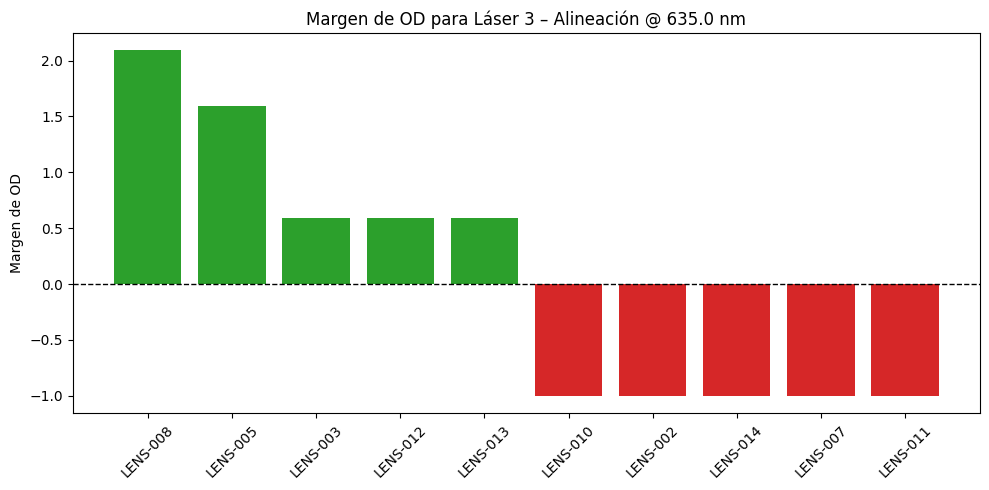

In [4]:
# Definición de escenarios base
LASERS = [
    {'name':'Láser 1 – PIV','lambda_nm':532.0,'mode':'pulsed','a_mm':5.0,'E_J':0.2,'HMPE':5.0e-7},
    {'name':'Láser 2 – LDA 514.5','lambda_nm':514.5,'mode':'CW','a_mm':1.2,'P_W':1.5,'HMPE':2.5e-3,'HMPE_long':1.0e-3},
    {'name':'Láser 3 – Alineación','lambda_nm':635.0,'mode':'CW','a_mm':3.0,'P_W':4.5e-3,'HMPE':2.5e-3},
]

def evaluate_and_plot(laser, lenses_df):
    res = evaluate_against_lenses(laser, lenses_df)
    if HAS_PANDAS:
        display(res.head(10))
        if HAS_MPL:
            # Top 10 por margen
            top = res.sort_values(['safe','margin','vlt_pct'], ascending=[False, False, False]).head(10)
            plt.figure(figsize=(10,5))
            colors = ['tab:green' if s else 'tab:red' for s in top['safe']]
            plt.bar(top['lens_id'], top['margin'].fillna(-1), color=colors)
            plt.axhline(0, color='k', linestyle='--', linewidth=1)
            plt.title(f"Margen de OD para {laser['name']} @ {laser['lambda_nm']} nm")
            plt.ylabel('Margen de OD')
            plt.xticks(rotation=45)
            plt.tight_layout()
            # Limpiar el nombre del láser para usarlo como nombre de archivo
            clean_name = laser['name'].replace(' ', '_').replace('–', '_').replace('.', '_').replace('á','a').replace('ó','o')
            save_path = f"../data/images/{clean_name}.png"
            try:
                plt.savefig(save_path)
                print(f"Gráfica guardada en: {save_path}")
            except Exception as e:
                print(f"Error al guardar gráfica: {e}")
            plt.show()
        else:
            print('Matplotlib no disponible: se omiten gráficos')
    else:
        print('Resultados (sin pandas):')
        for r in res[:10]:
            print(r)
    # Evaluación alternativa @10s si aplica
    if 'HMPE_long' in laser:
        laser2 = dict(laser)
        H0, units, _ = h0_exposure(laser2)
        od_req_long = od_required(H0, laser2['HMPE_long'])
        print(f"OD_req (exposición larga) @10 s: {od_req_long:.2f}")

# Ejecutar evaluación para cada láser base
for L in LASERS:
    print(f"\n=== {L['name']} ===")
    evaluate_and_plot(L, lenses)

In [5]:
# Widgets interactivos (si disponibles)
if HAS_WIDGETS:
    lam = widgets.FloatText(value=532.0, description='λ (nm)')
    mode = widgets.Dropdown(options=['CW','pulsed'], value='pulsed', description='Modo')
    a_mm = widgets.FloatText(value=5.0, description='a (mm)')
    P_W = widgets.FloatText(value=0.5, description='P (W)')
    E_J = widgets.FloatText(value=0.05, description='E (J)')
    HMPE = widgets.FloatText(value=5.0e-7, description='HMPE')
    vlt_min = widgets.IntSlider(value=0, min=0, max=90, step=5, description='VLT ≥ %')

    def run_custom(lam, mode, a_mm, P_W, E_J, HMPE, vlt_min):
        laser = {'name':'Custom','lambda_nm':lam,'mode':mode,'a_mm':a_mm,'HMPE':HMPE}
        if mode=='CW':
            laser['P_W'] = P_W
        else:
            laser['E_J'] = E_J
        res = evaluate_against_lenses(laser, lenses)
        if HAS_PANDAS:
            res2 = res[res['vlt_pct'] >= vlt_min].copy()
            display(res2.head(15))
            if HAS_MPL and len(res2):
                top = res2.sort_values(['safe','margin','vlt_pct'], ascending=[False, False, False]).head(12)
                plt.figure(figsize=(10,5))
                colors = ['tab:green' if s else 'tab:red' for s in top['safe']]
                plt.bar(top['lens_id'], top['margin'].fillna(-1), color=colors)
                plt.axhline(0, color='k', linestyle='--', linewidth=1)
                plt.title(f"Custom: margen OD @ {lam} nm")
                plt.ylabel('Margen de OD')
                plt.xticks(rotation=45)
                plt.tight_layout()
                save_path = f"../data/images/custom_laser_{lam}nm.png"
                try:
                    plt.savefig(save_path)
                    print(f"Gráfica guardada en: {save_path}")
                except Exception as e:
                    print(f"Error al guardar gráfica: {e}")
                plt.show()
        else:
            print('Widgets activos, pero sin pandas: mostrando 10 entradas')
            for r in res[:10]:
                print(r)

    ui = widgets.VBox([widgets.HBox([lam, mode, a_mm]), widgets.HBox([P_W, E_J, HMPE]), vlt_min])
    out = widgets.interactive_output(run_custom, {'lam': lam, 'mode': mode, 'a_mm': a_mm, 'P_W': P_W, 'E_J': E_J, 'HMPE': HMPE, 'vlt_min': vlt_min})
    display(ui, out)
else:
    print('ipywidgets no está disponible. Instala con: pip install ipywidgets')

Output()